In [1]:
import h5py
import os
import argparse
import glob
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate
import json

In [19]:
PRED_PATH = r"../repos/SynDiff/results/0506/exp_syndiff/generated_samples/epoch_9"
DATA_PATH = r"..\data\processed\BP_npy\0325_256_3_mini"
SCALE_PATH = r""

In [20]:
f  = h5py.File(os.path.join(PRED_PATH,"im_syn.mat"),'r')
target = f["images_contrast1syn"]
# f.close()
target.shape

(256, 256, 2000)

In [43]:
im_avg = np.average(target,axis=1)
out = im_avg.transpose(1,0)
im_avg.shape
# print(im_avg.shape,sbp.shape,dbp.shape)

(256, 2000)

### load true data

In [22]:
def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)

In [44]:
f2 = h5py.File(os.path.join(DATA_PATH,"data_test_contrast1.mat"),'r')
gt = f2['data_fs'][:]
gt.shape,type(gt)

((2000, 256), numpy.ndarray)

### load train data

In [28]:
scales = np.load(os.path.join(DATA_PATH,"scale_train.npy"))

In [26]:
f3 = h5py.File(os.path.join(DATA_PATH,"data_train_contrast1.mat"),'r')
train = f3['data_fs'][:,0]
train[:] -= scales[0,0]
train[:] /= scales[0,1]
train_mean = np.mean(train.flatten())
train_std = np.std(train.flatten())

### load scale

In [35]:
gt

array([[0.0831669 , 0.08354266, 0.08654867, ..., 0.17522597, 0.1680867 ,
        0.16094741],
       [0.09894846, 0.10120296, 0.10270597, ..., 0.16432919, 0.15944442,
        0.1571899 ],
       [0.07264587, 0.07339738, 0.07527613, ..., 0.16207467, 0.15794142,
        0.1541839 ],
       ...,
       [0.17935923, 0.1834925 , 0.19363777, ..., 0.61260045, 0.61936396,
        0.62349725],
       [0.32252046, 0.33755052, 0.3555866 , ..., 0.61485493, 0.61410344,
        0.61260045],
       [0.3082419 , 0.32402346, 0.34431404, ..., 0.6095944 , 0.6095944 ,
        0.60846716]], dtype=float32)

In [45]:
gt[:] -= scales[0,0]
gt[:] /= scales[0,1]
out[:] -= scales[0,0]
out[:] /= scales[0,1]

In [37]:
print(scales[0])

[-0.38464342  0.00769287]


In [14]:
gt.shape

(2000,)

In [46]:
gt_min,gt_max = calc_min_max(gt)
out_min,out_max = calc_min_max(out)
errors = np.zeros((2,*out_min.shape))
errors[0,:]=gt_min-out_min
errors[1,:]=gt_max-out_max
gt_mean = np.mean(gt.flatten())
out_mean = np.mean(out.flatten())
gt_std = np.std(gt.mean(axis=1),dtype=np.float64)
out_std = np.std(out.mean(axis=1),dtype=np.float64)
n_samples = errors.shape[1]
me = np.mean(errors,axis=1)
mae = np.mean(np.abs(errors),axis=1)
rmse = np.sqrt(np.mean(errors**2,axis=1))
std = np.std(errors,axis=1)
print(me.shape,mae.shape,rmse.shape,std.shape)
error_5 = np.count_nonzero(np.abs(errors)<=5,axis=1)/n_samples*100
error_15 = np.count_nonzero(np.abs(errors)<=15,axis=1)/n_samples*100
error_10 = np.count_nonzero(np.abs(errors)<=10,axis=1)/n_samples*100


(2,) (2,) (2,) (2,)


In [47]:
headers = ["Signal", "Mean","Std"]
table=[]
table.append(["train",train_mean,train_std])
table.append(["gt",gt_mean,gt_std])
table.append(["out",out_mean,out_std])
print(tabulate(table,headers, floatfmt=".4f"))

Signal        Mean      Std
--------  --------  -------
train      67.2915  11.2841
gt         89.0545  12.1211
out       107.3396   8.9865


In [48]:
print("""
          test data samples:
          # samples : {}
          
          Eval Stats:   DBP    SBP
          MAE:        {:6.3f} {:6.3f}
          RMSE:       {:6.3f} {:6.3f}
          Mean Error: {:6.3f} {:6.3f}
          STD:        {:6.3f} {:6.3f}
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
           
          
          """.format(
            n_samples,
            *mae,
            *rmse,
            *me,
            *std,
            error_5[0], error_10[0], error_15[0],
            error_5[1], error_10[1], error_15[1],
          ))



          test data samples:
          # samples : 2000
          
          Eval Stats:   DBP    SBP
          MAE:        10.271 46.453
          RMSE:       12.609 50.258
          Mean Error: -1.504 -46.350
          STD:        12.519 19.430
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      27.7%   55.1%   76.5%
          SBP       2.6%    5.2%    7.5%
           
          
          


In [49]:
gt_argmin,gt_argmax = np.argmin(gt,axis=1),np.argmax(gt,axis=1)
out_argmin,out_argmax = np.argmin(out,axis=1),np.argmax(out,axis=1)

1848


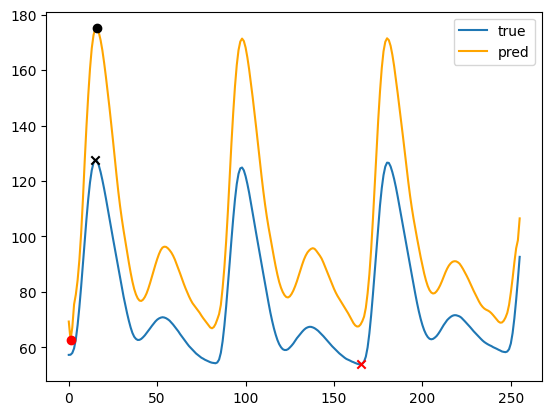

In [50]:
# asa = np.where(np.mean(out,axis=1)>0.8)[0]
# print(len(asa))
# i = asa[np.random.randint(56)]
# print(i)
i = np.random.randint(2000)
print(i)
plt.plot(gt[i],label='true')
plt.plot(out[i],c='orange',label='pred')
# plt.plot(cond[i],c='green',label='ppg')
plt.scatter(gt_argmax[i],gt_max[i],marker='x',c='black',zorder=2)
plt.scatter(gt_argmin[i],gt_min[i],marker='x',c='red',zorder=2)
plt.scatter(out_argmax[i],out_max[i],marker='o',c='black',zorder=2)
plt.scatter(out_argmin[i],out_min[i],marker='o',c='red',zorder=2)
plt.legend(loc='upper right')

(array([ 30.,  60., 103., 228., 258., 235., 351., 273., 170., 102.,  68.,
         64.,  43.,  14.,   1.]),
 array([-92.15666097, -84.85255091, -77.54844086, -70.2443308 ,
        -62.94022075, -55.63611069, -48.33200064, -41.02789058,
        -33.72378053, -26.41967047, -19.11556042, -11.81145036,
         -4.50734031,   2.79676975,  10.1008798 ,  17.40498986]),
 <BarContainer object of 15 artists>)

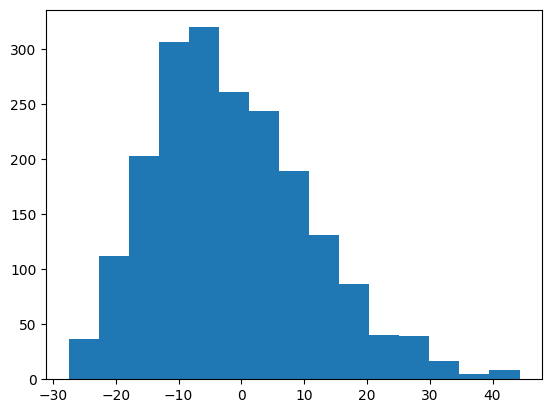

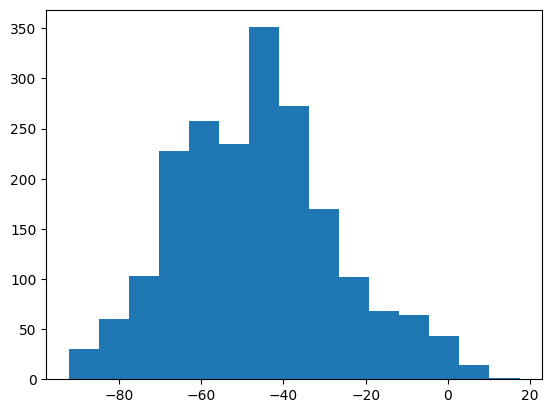

In [51]:
plt.hist(errors[0],bins=15)
plt.figure()
plt.hist(errors[1],bins=15)

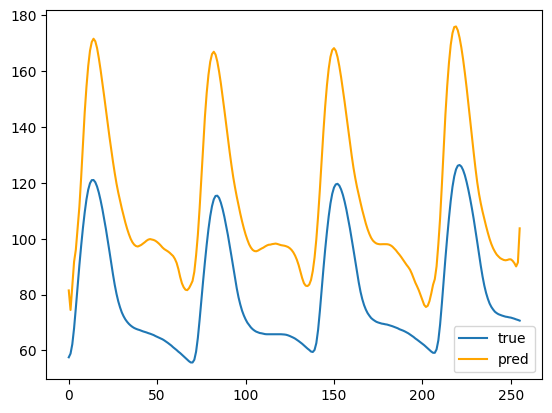

In [52]:
i = np.random.randint(2000)
plt.plot(gt[i],label='true')
plt.plot(out[i],c='orange',label='pred')
plt.legend()

(45.0, 130.0)

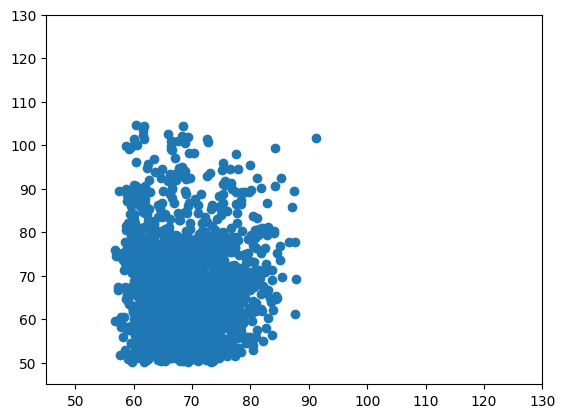

In [53]:
plt.scatter(out_min,gt_min)
plt.ylim([45,130])
plt.xlim([45,130])

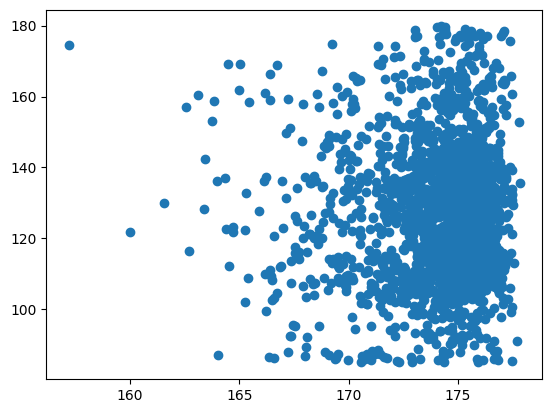

In [54]:
plt.scatter(out_max,gt_max)